In [1]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from builtins import range, input
from sklearn.metrics import confusion_matrix, roc_curve

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout

In [2]:
IMAGE_SIZE = 224 
epochs = 5
batch_size = 32
normalization_factor = 255

glaucoma_positive_train_path = 'glaucoma/Dataset/Train/Glaucoma_Positive'
glaucoma_negative_train_path = 'glaucoma/Dataset/Train/Glaucoma_Negative'


glaucoma_positive_test_path = 'glaucoma/Dataset/Test/Glaucoma_Positive'
glaucoma_negative_test_path = 'glaucoma/Dataset/Test/Glaucoma_Negative'

glaucoma_positive_train_files = glob(glaucoma_positive_train_path + '/*')
glaucoma_negative_train_files = glob(glaucoma_negative_train_path + '/*')

glaucoma_positive_test_files = glob(glaucoma_positive_test_path + '/*')
glaucoma_negative_test_files = glob(glaucoma_negative_test_path + '/*')
print(glaucoma_negative_train_path)

glaucoma/Dataset/Train/Glaucoma_Negative


In [3]:
glaucoma_positive_train_labels = []
glaucoma_negative_train_labels = []

glaucoma_positive_train_images=[]
glaucoma_negative_train_images=[]

glaucoma_positive_test_labels = []
glaucoma_negative_test_labels = []

glaucoma_positive_test_images=[]
glaucoma_negative_test_images=[]

for i in range(len(glaucoma_positive_train_files)):
  image = cv2.imread(glaucoma_positive_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_train_images.append(image)
  glaucoma_positive_train_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_train_files)):
  image = cv2.imread(glaucoma_negative_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_train_images.append(image)
  glaucoma_negative_train_labels.append('Glaucoma Negative')

for i in range(len(glaucoma_positive_test_files)):
  image = cv2.imread(glaucoma_positive_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_test_images.append(image)
  glaucoma_positive_test_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_test_files)):
  image = cv2.imread(glaucoma_negative_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_test_images.append(image)
  glaucoma_negative_test_labels.append('Glaucoma Negative')

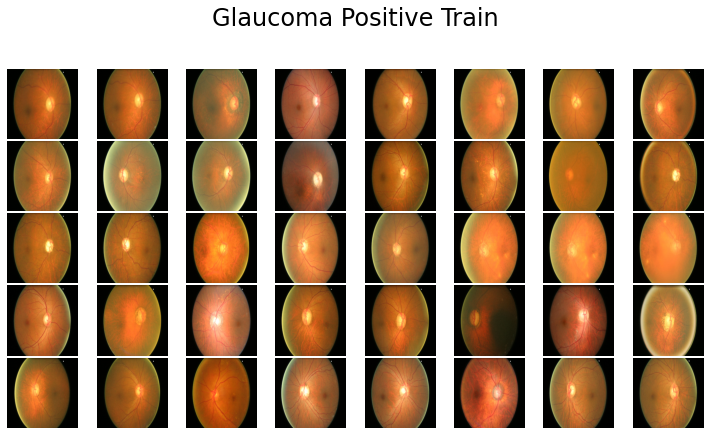

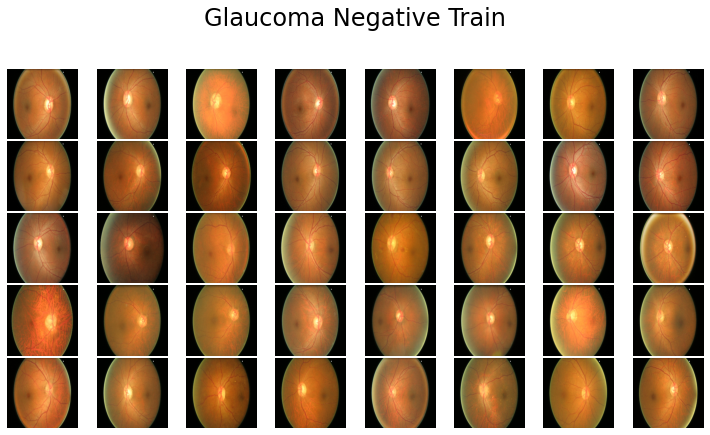

IndexError: list index out of range

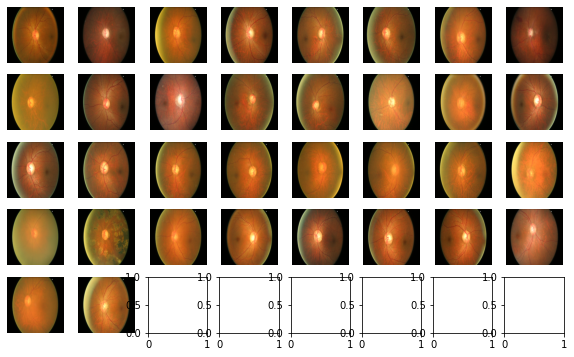

In [4]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()


plot_images(glaucoma_positive_train_images, 'Glaucoma Positive Train')
plot_images(glaucoma_negative_train_images, 'Glaucoma Negative Train')


plot_images(glaucoma_positive_test_images, 'Glaucoma Positive Test')
plot_images(glaucoma_negative_test_images, 'Glaucoma Negative Test')

In [5]:
glaucoma_positive_train_images = np.array(glaucoma_positive_train_images) / normalization_factor
glaucoma_negative_train_images = np.array(glaucoma_negative_train_images) / normalization_factor

glaucoma_positive_test_images = np.array(glaucoma_positive_test_images) / normalization_factor
glaucoma_negative_test_images = np.array(glaucoma_negative_test_images) / normalization_factor

In [6]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


X_train = np.concatenate((glaucoma_negative_train_images, glaucoma_positive_train_images), axis=0)
X_test = np.concatenate((glaucoma_negative_test_images, glaucoma_positive_test_images), axis=0)


y_train = np.concatenate((glaucoma_negative_train_labels, glaucoma_positive_train_labels), axis=0)
y_test = np.concatenate((glaucoma_negative_test_labels, glaucoma_positive_test_labels), axis=0)


y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

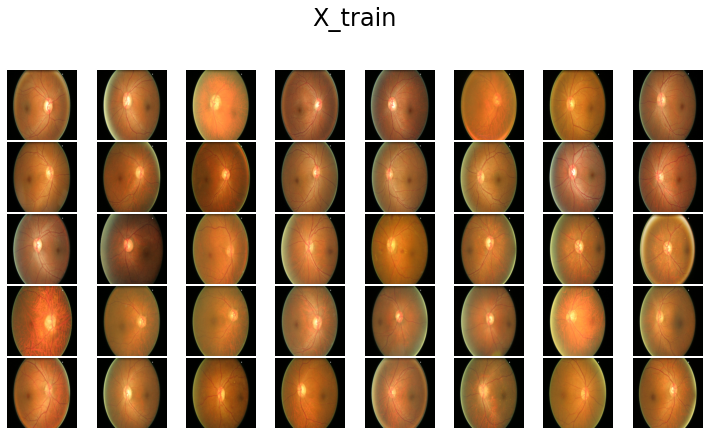

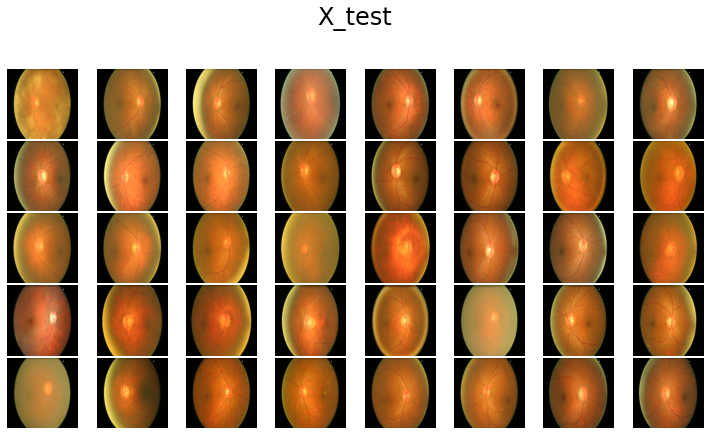

In [7]:
plot_images(X_train, 'X_train')
plot_images(X_test, 'X_test')

In [8]:
inception = InceptionResNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=5)

Epoch 1/5
16/16 [==============================] - 88s 5s/step - loss: 9.9447 - accuracy: 0.6231 - val_loss: 9.1992 - val_accuracy: 0.7385
Epoch 2/5
16/16 [==============================] - 75s 5s/step - loss: 4.6424 - accuracy: 0.6462 - val_loss: 1.0897 - val_accuracy: 0.6769
Epoch 3/5
16/16 [==============================] - 74s 5s/step - loss: 2.7403 - accuracy: 0.6462 - val_loss: 1.2671 - val_accuracy: 0.6538
Epoch 4/5
16/16 [==============================] - 75s 5s/step - loss: 1.6423 - accuracy: 0.7019 - val_loss: 1.8436 - val_accuracy: 0.5154
Epoch 5/5
16/16 [==============================] - 77s 5s/step - loss: 1.9908 - accuracy: 0.6577 - val_loss: 1.5264 - val_accuracy: 0.6000


In [11]:
y_pred = model.predict(X_test, batch_size=batch_size)

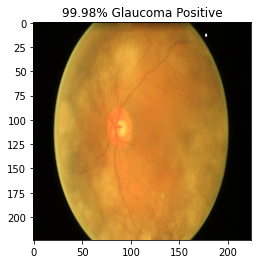

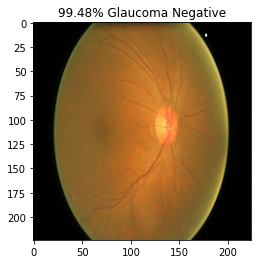

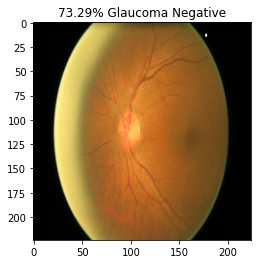

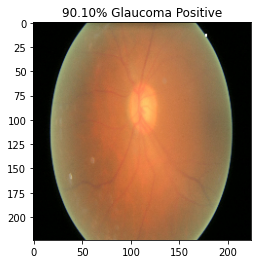

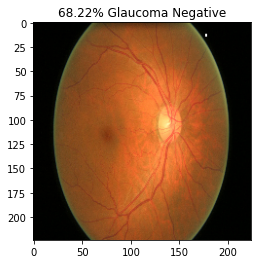

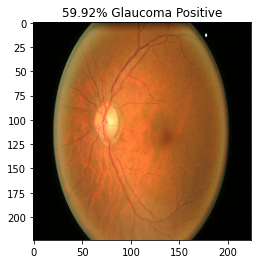

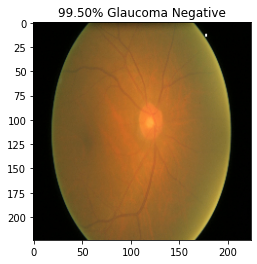

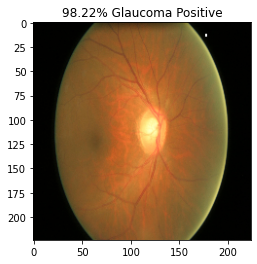

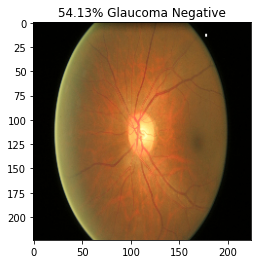

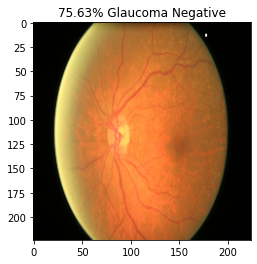

In [12]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Glaucoma Positive')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Glaucoma Negative')
  plt.imshow(X_test[index])
  plt.show()

In [13]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

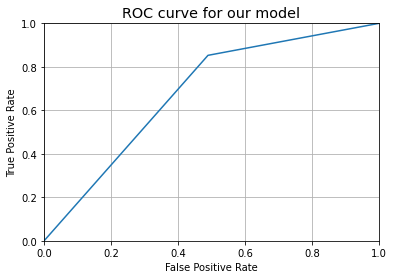

In [14]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


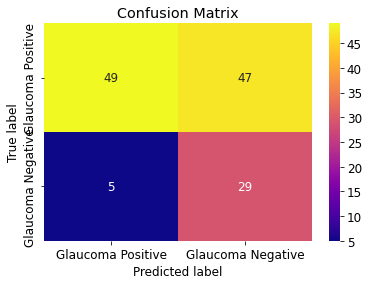

Confusion Matrix with Normalized Values


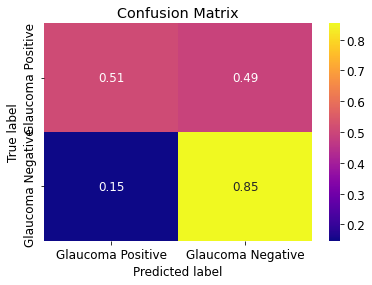

In [15]:
def plot_confusion_matrix(normalize):
  classes = ['Glaucoma Positive','Glaucoma Negative']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.91      0.51      0.65        96
           1       0.38      0.85      0.53        34

    accuracy                           0.60       130
   macro avg       0.64      0.68      0.59       130
weighted avg       0.77      0.60      0.62       130



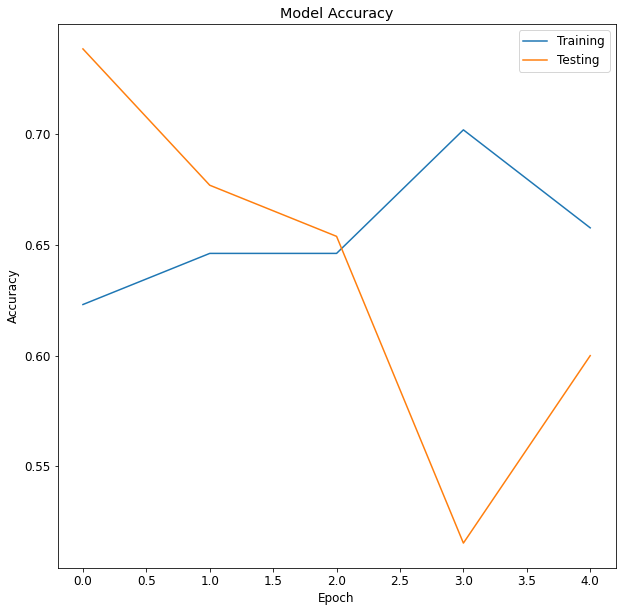

In [17]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_resnet_v2_glaucoma_accuracy.png')
plt.show()

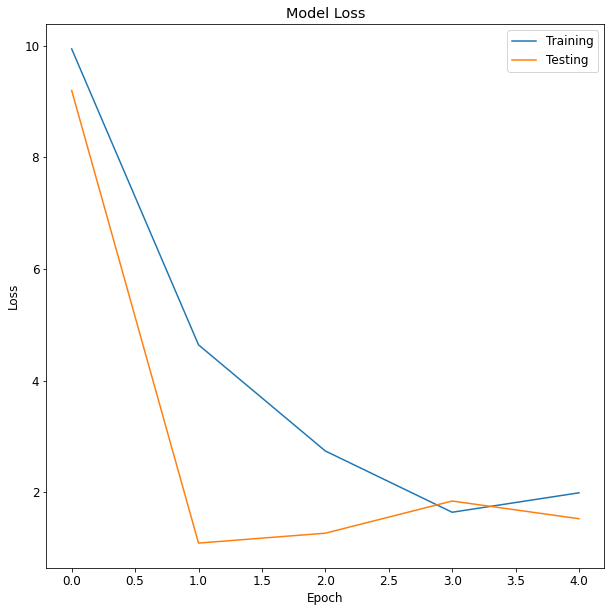

In [18]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_resnet_v2_glaucoma_loss.png')
plt.show()